In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
import seaborn as sn
import scipy.stats as scs
import scipy
from statsmodels.tools import add_constant
from statsmodels.discrete.discrete_model import Logit
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import itertools
plt.style.use("ggplot")

In [3]:
def plot_classification_thresholds(ax, X, y, inode, tree, xlim, ylim):
    threshold = tree.threshold[inode]
    if tree.feature[inode] == -2:
        color = ['r', 'b'][np.argmax(tree.value[inode])]
        ax.add_patch(Rectangle((xlim[0], ylim[0]), xlim[1]-xlim[0], ylim[1]-ylim[0], fc=color, alpha=0.3))
        return
    if tree.feature[inode] == 0:
        ax.plot((threshold, threshold), ylim, 'k', lw=0.5)
        plot_classification_thresholds(ax, X, y, tree.children_left[inode],  tree, (xlim[0], threshold), ylim)
        plot_classification_thresholds(ax, X, y, tree.children_right[inode], tree, (threshold, xlim[1]), ylim)
    else:
        ax.plot(xlim, (threshold, threshold), 'k', lw=0.5)
        plot_classification_thresholds(ax, X, y, tree.children_left[inode],  tree, xlim, (ylim[0], threshold))
        plot_classification_thresholds(ax, X, y, tree.children_right[inode], tree, xlim, (threshold, ylim[1]))

def plot_classification_tree(ax, X, y, model=None, fit = True):
    ax.plot(X[y==0, 0], X[y==0, 1], 'r.', label='False Positive')
    ax.plot(X[y==1, 0], X[y==1, 1], 'b.', label='Confirmed')
    ax.set_title("Classifying Exoplanets with Decision Trees")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(loc='upper left')
    
    if model is None:
        model = tree.DecisionTreeClassifier()
    if fit:
        model.fit(X, y)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    plot_classification_thresholds(ax, X, y, 0, model.tree_, xlim, ylim)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [4]:
pd_data = pd.read_csv('data/cumulative.csv')
pd_trim = pd_data[['kepid','koi_disposition','koi_pdisposition','koi_score','koi_period','koi_time0bk',
                   'koi_impact','koi_duration','koi_depth','koi_prad','koi_teq','koi_insol','koi_model_snr']]
pd_trim.dropna(inplace=True)
pd_trim['koi_disposition'].value_counts()
# pd_trim.shape

/home/lee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


FALSE POSITIVE    3922
CONFIRMED         2281
CANDIDATE         1792
Name: koi_disposition, dtype: int64

In [5]:
indexNames = pd_trim[pd_trim['koi_disposition'] == 'CANDIDATE'].index
pd_known = pd_trim.drop(indexNames)
pd_known['koi_disposition'].value_counts()
# pd_known.shape

FALSE POSITIVE    3922
CONFIRMED         2281
Name: koi_disposition, dtype: int64

In [6]:
pd_cand = pd_trim[pd_trim['koi_disposition'] == 'CANDIDATE']
pd_cand['koi_disposition'].value_counts()
np_cand = pd_cand['kepid'].to_numpy()
# name_cand = pd_cand['kepler_name'].copy()
np_cand

array([11138155, 11818800, 11918099, ..., 11911561,  8765560, 10128825])

In [7]:
pd_data.describe()

,rowid,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
count,9564.000000,9.564000e+03,8054.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9110.000000,9110.000000,...,9081.000000,9201.000000,9096.000000,9096.000000,9201.000000,9096.000000,9096.000000,9564.000000,9564.000000,9563.000000
mean,4782.500000,7.690628e+06,0.480829,0.188206,0.231598,0.194898,0.120033,75.671358,0.002148,-0.002148,...,-162.265059,4.310157,0.120738,-0.143161,1.728712,0.362292,-0.394806,292.060163,43.810433,14.264606
std,2761.033321,2.653459e+06,0.476928,0.390897,0.421875,0.396143,0.325018,1334.744046,0.008236,0.008236,...,72.746348,0.432606,0.132837,0.085477,6.127185,0.930870,2.168213,4.766657,3.601243,1.385448
min,1.000000,7.574500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.241843,0.000000,-0.172500,...,-1762.000000,0.047000,0.000000,-1.207000,0.109000,0.000000,-116.137000,279.852720,36.577381,6.966000
25%,2391.750000,5.556034e+06,0.000000,0.000000,0.000000,0.000000,0.000000,2.733684,0.000005,-0.000276,...,-198.000000,4.218000,0.042000,-0.196000,0.829000,0.129000,-0.250000,288.660770,40.777173,13.440000
50%,4782.500000,7.906892e+06,0.334000,0.000000,0.000000,0.000000,0.000000,9.752831,0.000035,-0.000035,...,-160.000000,4.438000,0.070000,-0.128000,1.000000,0.251000,-0.111000,292.261125,43.677504,14.520000
75%,7173.250000,9.873066e+06,0.998000,0.000000,0.000000,0.000000,0.000000,40.715178,0.000276,-0.000005,...,-114.000000,4.543000,0.149000,-0.088000,1.345000,0.364000,-0.069000,295.859160,46.714611,15.322000
max,9564.000000,1.293514e+07,1.000000,1.000000,1.000000,1.000000,1.000000,129995.778400,0.172500,0.000000,...,0.000000,5.364000,1.472000,0.000000,229.908000,33.091000,0.000000,301.720760,52.336010,20.003000


In [8]:
stat_conf = pd_data[pd_data['koi_disposition'] == 'CONFIRMED']
conv_sum = stat_conf.describe()
conv_sum.to_csv('confirmed.csv')

In [9]:
stat_cand = pd_data[pd_data['koi_disposition'] == 'CANDIDATE']
conv_sum = stat_cand.describe()
conv_sum.to_csv('candidate.csv')

In [10]:
stat_fpos = pd_data[pd_data['koi_disposition'] == 'FALSE POSITIVE']
fpos_sum = stat_fpos.describe()
fpos_sum.to_csv('false_pos.csv')

In [11]:
# pd_trim.describe()
pd_trim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7995 entries, 0 to 9563
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   kepid             7995 non-null   int64  
 1   koi_disposition   7995 non-null   object 
 2   koi_pdisposition  7995 non-null   object 
 3   koi_score         7995 non-null   float64
 4   koi_period        7995 non-null   float64
 5   koi_time0bk       7995 non-null   float64
 6   koi_impact        7995 non-null   float64
 7   koi_duration      7995 non-null   float64
 8   koi_depth         7995 non-null   float64
 9   koi_prad          7995 non-null   float64
 10  koi_teq           7995 non-null   float64
 11  koi_insol         7995 non-null   float64
 12  koi_model_snr     7995 non-null   float64
dtypes: float64(10), int64(1), object(2)
memory usage: 1.2+ MB


In [12]:
pd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              9564 non-null   int64  
 1   kepid              9564 non-null   int64  
 2   kepoi_name         9564 non-null   object 
 3   kepler_name        2294 non-null   object 
 4   koi_disposition    9564 non-null   object 
 5   koi_pdisposition   9564 non-null   object 
 6   koi_score          8054 non-null   float64
 7   koi_fpflag_nt      9564 non-null   int64  
 8   koi_fpflag_ss      9564 non-null   int64  
 9   koi_fpflag_co      9564 non-null   int64  
 10  koi_fpflag_ec      9564 non-null   int64  
 11  koi_period         9564 non-null   float64
 12  koi_period_err1    9110 non-null   float64
 13  koi_period_err2    9110 non-null   float64
 14  koi_time0bk        9564 non-null   float64
 15  koi_time0bk_err1   9110 non-null   float64
 16  koi_time0bk_err2   9110 

In [13]:
pd_wider = pd_data[['koi_disposition','koi_period','koi_time0bk','koi_impact',
                   'koi_duration','koi_depth','koi_prad','koi_teq','koi_insol',
                   'koi_model_snr','koi_steff','koi_slogg','koi_srad','koi_kepmag']]
pd_wider.dropna(inplace=True)

indexNames = pd_wider[pd_wider['koi_disposition'] == 'CANDIDATE'].index
pd_wide = pd_wider.drop(indexNames)
pd_wide['koi_disposition'].value_counts()

/home/lee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


FALSE POSITIVE    4723
CONFIRMED         2292
Name: koi_disposition, dtype: int64

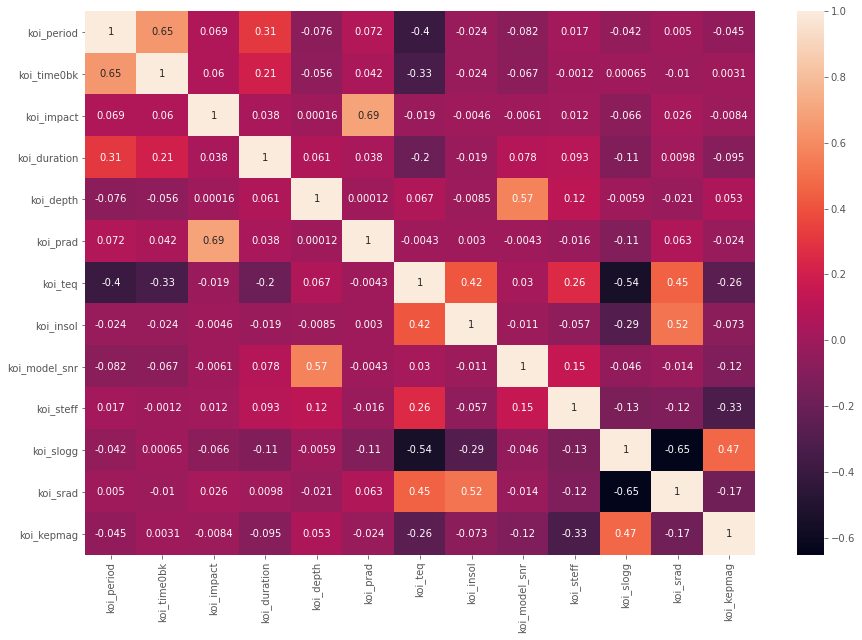

In [14]:
corrMatrix = pd_wide.corr()
plt.figure(figsize=(15,10))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [15]:
pd_wide['koi_disposition'].value_counts()

FALSE POSITIVE    4723
CONFIRMED         2292
Name: koi_disposition, dtype: int64

(array([1792.,    0.,    0.,    0.,    0., 3922.,    0.,    0.,    0.,
        2281.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

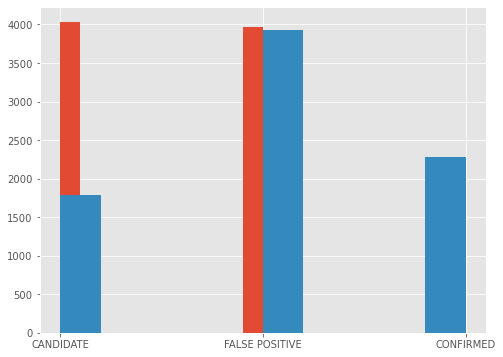

In [16]:
plt.figure(figsize=(8,6))
plt.hist(pd_trim['koi_pdisposition'], label="guess")
plt.hist(pd_trim['koi_disposition'], label="conclusion")

In [17]:
pd_trim['koi_disposition'].value_counts()

FALSE POSITIVE    3922
CONFIRMED         2281
CANDIDATE         1792
Name: koi_disposition, dtype: int64

In [18]:
y_f = pd_wide['koi_disposition'].apply(lambda x: 1 if x == "FALSE POSITIVE" else 0)
y_c = pd_wide['koi_disposition'].apply(lambda x: 1 if x == "CONFIRMED" else 0)
# X = pd_wide.drop(columns=['koi_disposition']).copy().values
X = pd_wide.drop(columns=['koi_disposition']).to_numpy()
X_const = add_constant(X, prepend=True)

In [19]:
X_normalized = normalize(X)
X_train,X_test,y_train,y_test=train_test_split(X,y_c,test_size=0.2,random_state=0)

In [20]:
lasso_regularization_strengths = np.logspace(
    np.log10(10e-6), np.log10(10), num=100 )

l_try = Lasso(alpha=0.01)
l_try.fit(X_train, y_train)
l_try.score(X_train, y_train)

0.26208686565162265

In [21]:
logit_model = Logit(y_c, X).fit()
# logit_model = Logit(y, X_normalized).fit()
model = LogisticRegression(max_iter=10000).fit(X, y_c)
model.predict(X)
model.predict_proba(X)
model.score(X, y_c)

/home/lee/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.369220
         Iterations 15


0.835495367070563

In [22]:
logit_model.summary()

/home/lee/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        koi_disposition   No. Observations:                 7015
Model:                          Logit   Df Residuals:                     7002
Method:                           MLE   Df Model:                           12
Date:                Fri, 28 Aug 2020   Pseudo R-squ.:                  0.4156
Time:                        13:44:15   Log-Likelihood:                -2590.1
converged:                       True   LL-Null:                       -4432.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0156      0.001    -18.566      0.000      -0.017      -0.014
x2             0.0041      0.001      4.395      0.000       0.002       0.006
x3            -0.5830      0.111     -5.264      0.000      -0.800      -0.366
x4            -0.0821      0.010     -8.515      0.000      -0.101      -0.063
x5            -0.0001   1.52e-05     -6.969      0.000      -0.000    -7.6e-05
x6            -0.1084      0.010    -11.082      0.000      -0.128      -0.089
x7            -0.0025      0.000    -17.007      0.000      -0.003      -0.002
x8         -6.533e-05   4.19e-05     -1.560      0.119      -0.000    1.67e-05
x9             0.0018      0.000      9.357      0.000       0.001       0.002
x10            0.0003   4.95e-05      5.886      0.000       0.000       0.000
x11            0.3120      0.119      2.617      0.009       0.078       0.546
x12            0.2458      0.025      9.729      0.000       0.196       0.295
x13            0.0014      0.033      0.044      0.965      -0.062       0.065
==============================================================================

Possibly complete quasi-separation: A fraction 0.17 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [23]:
# pd_wider[['koi_disposition','koi_score','koi_period','koi_time0bk','koi_impact',
#                    'koi_duration','koi_depth','koi_prad','koi_teq','koi_insol',
#                    'koi_model_snr','koi_steff','koi_slogg','koi_srad','koi_kepmag']]
pd_try = pd_wide[['koi_disposition','koi_period','koi_time0bk','koi_impact',
                    'koi_depth','koi_prad','koi_teq',
                    'koi_model_snr','koi_steff','koi_srad']]

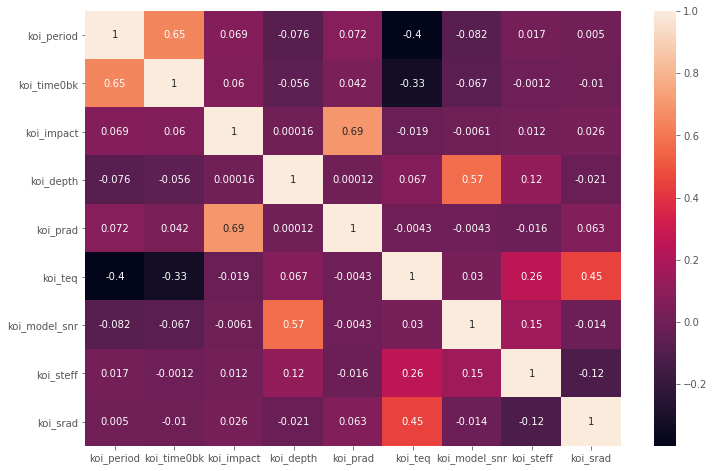

In [24]:
corrMatrix = pd_try.corr()
plt.figure(figsize=(12,8))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [25]:
X = pd_try.drop(columns=['koi_disposition']).to_numpy()
X_const = add_constant(X, prepend=True)

In [26]:
X_normalized = normalize(X)
X_train,X_test,y_train,y_test=train_test_split(X,y_c,test_size=0.2,random_state=0)

In [27]:
lasso_regularization_strengths = np.logspace(
    np.log10(10e-6), np.log10(10), num=100 )

l_try = Lasso(alpha=0.01)
l_try.fit(X_train, y_train)
l_try.score(X_train, y_train)

0.22560050671101994

In [28]:
logit_model = Logit(y_c, X).fit()
# logit_model = Logit(y, X_normalized).fit()
model = LogisticRegression(max_iter=10000).fit(X, y_c)
model.predict(X)
model.predict_proba(X)
model.score(X, y_c)

Optimization terminated successfully.
         Current function value: 0.379317
         Iterations 15


/home/lee/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


0.8245188880969352

In [29]:
logit_model.summary()

/home/lee/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        koi_disposition   No. Observations:                 7015
Model:                          Logit   Df Residuals:                     7006
Method:                           MLE   Df Model:                            8
Date:                Fri, 28 Aug 2020   Pseudo R-squ.:                  0.3997
Time:                        13:44:24   Log-Likelihood:                -2660.9
converged:                       True   LL-Null:                       -4432.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0187      0.001    -23.387      0.000      -0.020      -0.017
x2             0.0071      0.001      8.139      0.000       0.005       0.009
x3            -0.6506      0.107     -6.085      0.000      -0.860      -0.441
x4         -9.375e-05   1.37e-05     -6.820      0.000      -0.000   -6.68e-05
x5            -0.1128      0.009    -11.959      0.000      -0.131      -0.094
x6            -0.0025   9.11e-05    -26.940      0.000      -0.003      -0.002
x7             0.0017      0.000      9.224      0.000       0.001       0.002
x8             0.0004   3.04e-05     13.598      0.000       0.000       0.000
x9             0.1714      0.015     11.569      0.000       0.142       0.200
==============================================================================

Possibly complete quasi-separation: A fraction 0.16 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [30]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(max_iter=1000)

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

In [31]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[789, 171],
       [ 94, 349]])

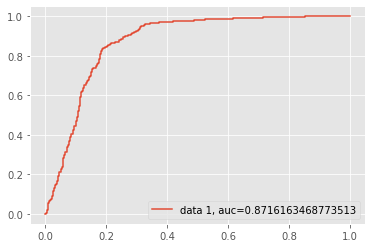

In [32]:
y_pred_proba = logreg.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

[Text(213.34859095982142, 206.56799999999998, 'X[4] <= 13.62\ngini = 0.44\nsamples = 7015\nvalue = [4723, 2292]'),
 Text(128.04885602678573, 184.824, 'X[6] <= 14.55\ngini = 0.498\nsamples = 4817\nvalue = [2550, 2267]'),
 Text(53.667020089285714, 163.07999999999998, 'X[6] <= 11.25\ngini = 0.216\nsamples = 1592\nvalue = [1396, 196]'),
 Text(32.228236607142854, 141.336, 'X[0] <= 35.772\ngini = 0.075\nsamples = 1030\nvalue = [990, 40]'),
 Text(18.122544642857143, 119.592, 'X[3] <= 353.45\ngini = 0.144\nsamples = 486\nvalue = [448, 38]'),
 Text(7.099553571428571, 97.848, 'X[0] <= 4.335\ngini = 0.091\nsamples = 439\nvalue = [418, 21]'),
 Text(2.9892857142857143, 76.10399999999998, 'X[2] <= 0.004\ngini = 0.007\nsamples = 269\nvalue = [268, 1]'),
 Text(1.4946428571428572, 54.360000000000014, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(4.483928571428572, 54.360000000000014, 'gini = 0.0\nsamples = 268\nvalue = [268, 0]'),
 Text(11.209821428571429, 76.10399999999998, 'X[6] <= 9.45\ngini = 0

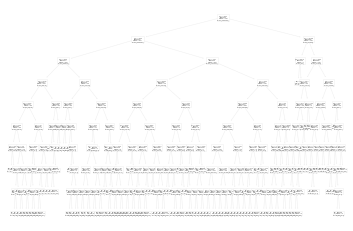

In [33]:
tree_depth = 9
dtc = tree.DecisionTreeClassifier(max_depth=tree_depth)
dtc = dtc.fit(X, y_c)
tree.plot_tree(dtc) 

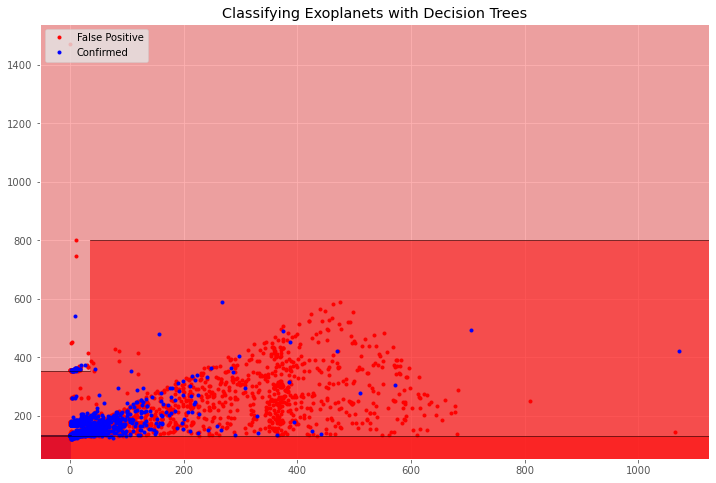

In [34]:
model_dt = tree.DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 10)
fig, ax = plt.subplots(figsize=(12,8))
plot_classification_tree(ax, X, y_c, model_dt)

In [35]:
y_pred = model_dt.predict(X_test)
print("Accuracy: ",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:   ",metrics.recall_score(y_test, y_pred))

Accuracy:  0.879543834640057
Precision: 0.7686274509803922
Recall:    0.8848758465011287


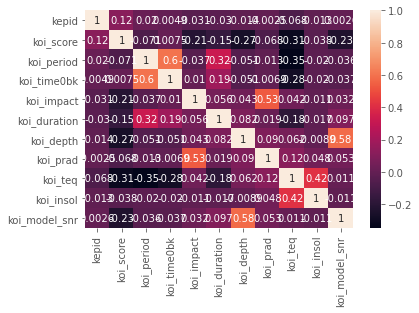

In [36]:
corrMatrix = pd_known.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [37]:
# X = pd_known[['koi_period','koi_time0bk',
#                    'koi_impact','koi_duration','koi_depth','koi_prad','koi_teq','koi_insol','koi_model_snr']].copy().values
X = pd_known[['koi_period','koi_time0bk',
                   'koi_impact','koi_duration','koi_depth','koi_prad','koi_teq','koi_insol','koi_model_snr']].to_numpy()
X_const = add_constant(X, prepend=True)
y_f = pd_known['koi_disposition'].apply(lambda x: 1 if x == "FALSE POSITIVE" else 0)
y_c = pd_known['koi_disposition'].apply(lambda x: 1 if x == "CONFIRMED" else 0)
# y.describe()

In [38]:
pd_cand

,kepid,koi_disposition,koi_pdisposition,koi_score,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr
37,11138155,CANDIDATE,CANDIDATE,1.000,4.959319,172.258529,0.831,2.22739,9802.0,12.21,1103.0,349.40,696.5
58,11818800,CANDIDATE,CANDIDATE,0.999,40.419504,173.564690,0.911,3.36200,6256.0,7.51,467.0,11.29,36.9
62,11918099,CANDIDATE,CANDIDATE,0.993,7.240661,137.755450,1.198,0.55800,556.4,19.45,734.0,68.63,13.7
63,9579641,CANDIDATE,CANDIDATE,0.871,3.435916,132.662400,0.624,3.13300,23.2,0.55,1272.0,617.61,8.7
72,3246984,CANDIDATE,CANDIDATE,0.773,1.626630,169.820171,1.260,2.11450,1620.6,32.43,1547.0,1355.88,103.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9550,8488381,CANDIDATE,CANDIDATE,0.532,4.736816,131.787600,0.218,2.84000,35.3,0.60,1137.0,395.05,6.9
9551,8489260,CANDIDATE,CANDIDATE,0.386,130.235324,218.271900,0.075,5.67800,750.1,2.44,332.0,2.86,9.7
9557,11911561,CANDIDATE,CANDIDATE,1.000,8.870416,137.481093,1.206,1.28640,873.1,39.46,1151.0,414.26,43.8
9558,8765560,CANDIDATE,CANDIDATE,1.000,47.109631,144.131720,1.230,5.74100,752.2,78.98,751.0,75.40,35.1


In [39]:
# Nine astype('float32') assignments below added to resolve this error message:
# Input contains NaN, infinity or a value too large for dtype('float32')
#

# pd_cand.koi_period = pd_cand.koi_period.astype('float32')
# pd_cand.koi_time0bk = pd_cand.koi_time0bk.astype('float32')
# pd_cand.koi_impact = pd_cand.koi_impact.astype('float32')
# pd_cand.koi_duration = pd_cand.koi_duration.astype('float32')
# pd_cand.koi_depth = pd_cand.koi_depth.astype('float32')
# pd_cand.koi_prad = pd_cand.koi_prad.astype('float32')
# pd_cand.koi_teq = pd_cand.koi_teq.astype('float32')
# pd_cand.koi_insol = pd_cand.koi_insol.astype('float32')
# pd_cand.koi_model_snr = pd_cand.koi_model_snr.astype('float32')
X_cand = pd_cand[['koi_period','koi_time0bk','koi_impact','koi_duration','koi_depth',
                  'koi_prad','koi_teq','koi_insol','koi_model_snr']].to_numpy()
# X = pd_known[['koi_period','koi_time0bk','koi_impact','koi_duration','koi_depth',
#               'koi_prad','koi_teq','koi_insol','koi_model_snr']].to_numpy()

X_cand.shape

(1792, 9)

In [40]:
X_cand_check = pd_cand[['koi_period','koi_time0bk','koi_impact','koi_duration','koi_depth',
                  'koi_prad','koi_teq','koi_insol','koi_model_snr']].copy()
X_cand_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1792 entries, 37 to 9561
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   koi_period     1792 non-null   float64
 1   koi_time0bk    1792 non-null   float64
 2   koi_impact     1792 non-null   float64
 3   koi_duration   1792 non-null   float64
 4   koi_depth      1792 non-null   float64
 5   koi_prad       1792 non-null   float64
 6   koi_teq        1792 non-null   float64
 7   koi_insol      1792 non-null   float64
 8   koi_model_snr  1792 non-null   float64
dtypes: float64(9)
memory usage: 140.0 KB


In [41]:
X_cand = X_cand_check.values

In [42]:
X_normalized = normalize(X)

In [43]:
X_train,X_test,y_train,y_test=train_test_split(X,y_c,test_size=0.2,random_state=0)

In [44]:
lasso_regularization_strengths = np.logspace(
    np.log10(10e-6), np.log10(10), num=100 )

l_try = Lasso(alpha=0.01)
l_try.fit(X_train, y_train)
l_try.score(X_train, y_train)

0.28061390111589424

In [45]:
logit_model = Logit(y_c, X).fit()
# logit_model = Logit(y, X_normalized).fit()
model = LogisticRegression(max_iter=1000).fit(X, y_c)
model.predict(X)
model.predict_proba(X)
model.score(X, y_c)

Optimization terminated successfully.
         Current function value: 0.388890
         Iterations 12


/home/lee/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


0.8379816217959052

In [46]:
logit_model.summary()

/home/lee/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        koi_disposition   No. Observations:                 6203
Model:                          Logit   Df Residuals:                     6194
Method:                           MLE   Df Model:                            8
Date:                Fri, 28 Aug 2020   Pseudo R-squ.:                  0.4087
Time:                        13:44:51   Log-Likelihood:                -2412.3
converged:                       True   LL-Null:                       -4079.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0132      0.001    -14.109      0.000      -0.015      -0.011
x2             0.0154      0.001     17.429      0.000       0.014       0.017
x3            -0.4325      0.108     -4.015      0.000      -0.644      -0.221
x4            -0.0498      0.009     -5.656      0.000      -0.067      -0.033
x5            -0.0001   1.62e-05     -7.168      0.000      -0.000   -8.44e-05
x6            -0.1101      0.009    -12.663      0.000      -0.127      -0.093
x7            -0.0008      0.000     -5.739      0.000      -0.001      -0.001
x8            -0.0005   6.52e-05     -7.122      0.000      -0.001      -0.000
x9             0.0019      0.000      9.214      0.000       0.001       0.002
==============================================================================

Possibly complete quasi-separation: A fraction 0.19 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [47]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(max_iter=10000)

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

In [48]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[645, 131],
       [ 69, 396]])

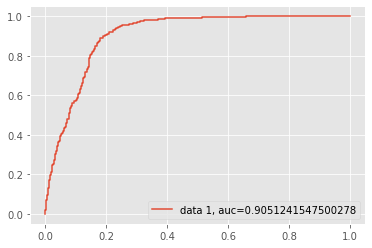

In [49]:
y_pred_proba = logreg.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

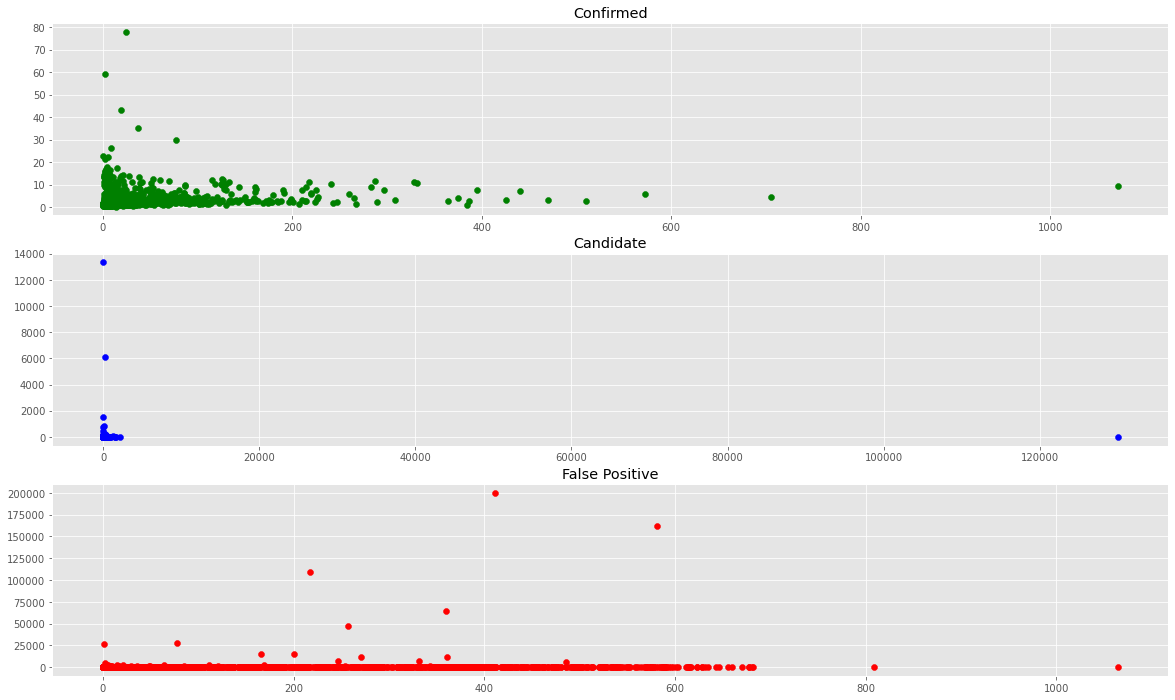

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,figsize = (20,12))
ax1.scatter(stat_conf["koi_period"], stat_conf["koi_prad"], color="green")
ax1.set_title("Confirmed")

ax2.scatter(stat_cand["koi_period"], stat_cand["koi_prad"], color="blue")
ax2.set_title("Candidate")

ax3.scatter(stat_fpos["koi_period"], stat_fpos["koi_prad"], color="red")
ax3.set_title("False Positive")

plt.show()

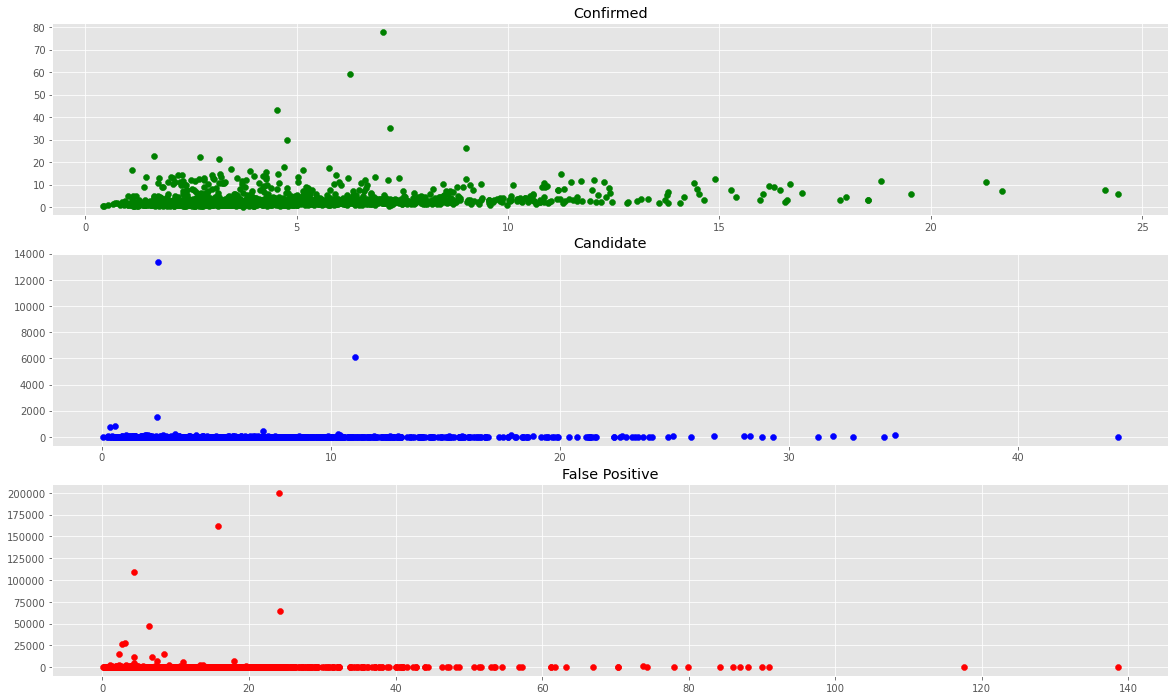

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,figsize = (20,12))
ax1.scatter(stat_conf["koi_duration"], stat_conf["koi_prad"], color="green")
ax1.set_title("Confirmed")

ax2.scatter(stat_cand["koi_duration"], stat_cand["koi_prad"], color="blue")
ax2.set_title("Candidate")

ax3.scatter(stat_fpos["koi_duration"], stat_fpos["koi_prad"], color="red")
ax3.set_title("False Positive")

plt.show()

[Text(220.82677970852018, 206.56799999999998, 'X[5] <= 13.48\ngini = 0.465\nsamples = 6203\nvalue = [3922, 2281]'),
 Text(138.85098094170405, 184.824, 'X[0] <= 2.319\ngini = 0.495\nsamples = 4113\nvalue = [1858, 2255]'),
 Text(74.64501121076233, 163.07999999999998, 'X[1] <= 133.008\ngini = 0.276\nsamples = 1046\nvalue = [873, 173]'),
 Text(44.94652466367713, 141.336, 'X[3] <= 1.953\ngini = 0.198\nsamples = 863\nvalue = [767, 96]'),
 Text(27.399551569506727, 119.592, 'X[6] <= 1899.0\ngini = 0.323\nsamples = 371\nvalue = [296, 75]'),
 Text(15.764125560538117, 97.848, 'X[8] <= 14.9\ngini = 0.438\nsamples = 201\nvalue = [136, 65]'),
 Text(7.506726457399103, 76.10399999999998, 'X[0] <= 2.255\ngini = 0.155\nsamples = 71\nvalue = [65, 6]'),
 Text(6.005381165919283, 54.360000000000014, 'X[7] <= 2703.31\ngini = 0.133\nsamples = 70\nvalue = [65, 5]'),
 Text(3.0026905829596413, 32.615999999999985, 'X[2] <= 0.821\ngini = 0.089\nsamples = 64\nvalue = [61, 3]'),
 Text(1.5013452914798207, 10.87200000

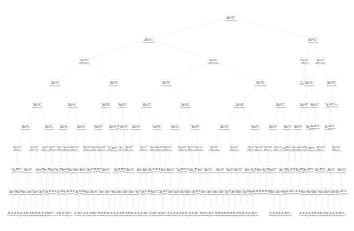

In [52]:
tree_depth = 9
dtc = tree.DecisionTreeClassifier(max_depth=tree_depth)
dtc = dtc.fit(X, y_c)
tree.plot_tree(dtc) 

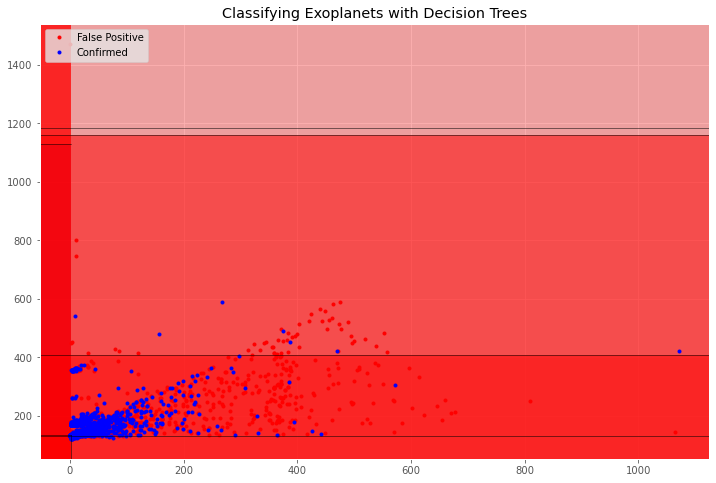

In [53]:
model_dt = tree.DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 10)
fig, ax = plt.subplots(figsize=(12,8))
plot_classification_tree(ax, X, y_c, model_dt)

In [54]:
y_pred = model_dt.predict(X_test)
print("Accuracy: ",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:   ",metrics.recall_score(y_test, y_pred))

Accuracy:  0.8879935535858179
Precision: 0.8234126984126984
Recall:    0.8924731182795699


In [55]:
y_decision = model_dt.predict(X_cand)
unique_elements, counts_elements = np.unique(y_decision, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[  0   1]
 [950 842]]


In [56]:
exo_r = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=0)
X_rf, y_rf = make_classification(n_samples=2000, n_features=8, shuffle=False)
exo_r.fit(X_train,y_train)

y_pred=exo_r.predict(X_test)
print("Accuracy: ",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:   ",metrics.recall_score(y_test, y_pred))

Accuracy:  0.895245769540693
Precision: 0.8252427184466019
Recall:    0.9139784946236559


In [57]:
exo_r.fit(X_test,y_test)

y_pred=exo_r.predict(X_test)
print("Accuracy: ",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:   ",metrics.recall_score(y_test, y_pred))

Accuracy:  0.9331184528605962
Precision: 0.8804780876494024
Recall:    0.9505376344086022


In [58]:
y_decision = model_dt.predict(X_cand)
unique_elements, counts_elements = np.unique(y_decision, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[  0   1]
 [950 842]]


In [59]:
y_random = exo_r.predict(X_cand)
unique_elements, counts_elements = np.unique(y_random, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1]
 [1013  779]]


(array([882.,   0.,   0.,   0.,   0., 199.,   0.,   0.,   0., 711.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

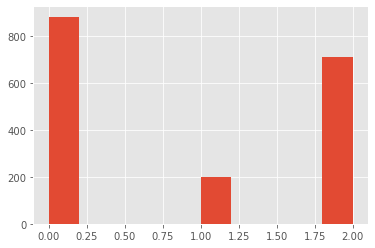

In [60]:
y_likely = y_decision + y_random
plt.hist (y_likely)

In [61]:
possibles = pd.DataFrame({'kepid': np_cand, 'decision_tree': y_decision, 'random_forest': y_random},
                         columns=['kepid', 'decision_tree', 'random_forest'])
possibles

,kepid,decision_tree,random_forest
0,11138155,1,1
1,11818800,1,1
2,11918099,0,0
3,9579641,0,0
4,3246984,0,0
...,...,...,...
1787,8488381,0,0
1788,8489260,0,0
1789,11911561,0,0
1790,8765560,0,0
